## Conditional Variational Autoencoder

In this project, we'll implement a conditional variational autoencoder. As you may already know, an autoencoder is a model that learns a representation from which the original image can be regenerated. One of the challenges of using an autoencoder directly for generating samples is that the representation space tends not to be as smooth. If you try to sample a random vector in the space and feed it into the decoder, the results may be undesirable. The problem is the standard autoencoder may have sharp discontinuities within the space, where the region between the two classes either produces noise outputs or suddely changes (i.e. one vector looks like class X, but a very close vector suddenly looks like class Y - with a large jump). This is because a standard autoencoder learns a deterministic mapping from the input to the latent representation and back. Variational autoencoders addresses this issue by introducing randomness in the latent representation.

In a VAE, the encoder predicts the parameters of a probability distribution in the latent space, rather than a single representation (aka an embedding). To generate a sample, a latent vector is drawn randomly from this predicted distribution, and then passed through the decoder to generate the output. The key idea is that the randomness baked into the latent space allows the VAE to better generate diverse samples that were not present in the training data because the space is smoother.

In addition, the VAE objective function includes a regularization term which encourages the learned latent distribution to be close to a predefined prior distribution. This regularization helps to smooth the latent space, making it more continuous and well-behaved, which in turn leads to better generated samples.

In this notebook, we'll be implementing a conditional variational autoencoder (i.e. one that is also conditioned on the class label). You'll be training your autoencoder on the famous MNIST dataset of handwritten digits.

## Google Colab Setup
The following part only applies to students using Colab. If you're not using Colab, feel free to delete this.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
datadir = "/path/to/the/project/" # path to the project
if not os.path.exists(datadir):
  !ln -s "" $datadir # path to the homework
os.chdir(datadir)
!pwd

/content/drive/MyDrive/Colab Notebooks/Intro to DL Course/HW3/part3


## Starter code

In [ ]:
%load_ext autoreload
%autoreload 2 # This allows you to edit the .py source files and those updates also translate to the notebook

In [ ]:
import time, os, sys
import cs5814_vae

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
%matplotlib inline

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## MNIST Dataset

Generative models can be difficult to train. To simplify issues, we'll use the MNIST dataset that is a famous dataset for handwritten digit recognition.

Once again, fortunately for us PyTorch has the MNIST dataset [already implemented.](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html)

In [ ]:
batch_size = 128

mnist_train = datasets.MNIST('./MNIST_data_directory', train=True, download=True,
                           transform=T.ToTensor())
data_loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          shuffle=True, drop_last=True, num_workers=2)

In [ ]:
## Visualize Data Samples
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def display_data(data_tensors):
    data_tensors = torch.reshape(data_tensors, [data_tensors.shape[0], -1])

    shape = int(math.ceil(math.sqrt(data_tensors.shape[0])))
    data_dim = int(math.ceil(math.sqrt(data_tensors.shape[1])))

    fig = plt.figure(figsize=(shape, shape))
    grid_spec = gridspec.GridSpec(shape, shape)
    grid_spec.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(data_tensors):
        ax = plt.subplot(grid_spec[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape([data_dim, data_dim]))
    return

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


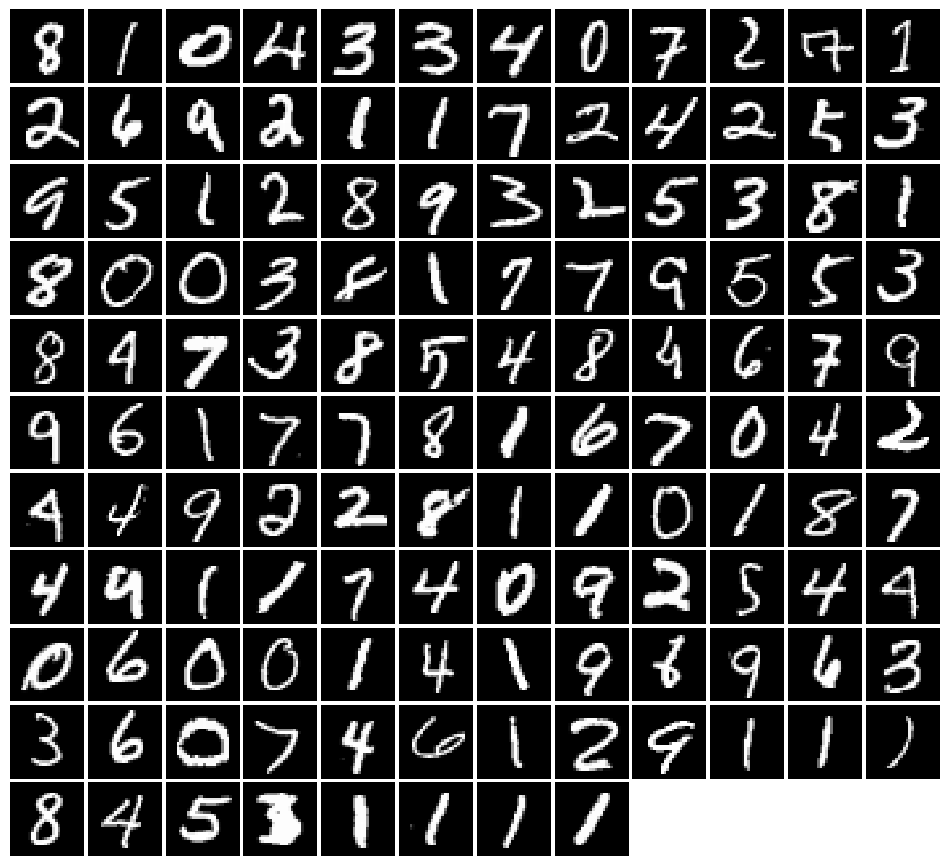

In [ ]:
# imgs = data_loader_train.__iter__().next()[0].view(batch_size, 784) # Let's visualize a batch of images
imgs = next(iter(data_loader_train))[0].view(batch_size, 784)
# show_images(imgs)
display_data(imgs)

## Model architecture

Our latent variable model will consist solely of linear (dense) layers. We'll take the input tensor shape and flatten it to create a single input vector dimension. We'll concatenate the image with a one hot vector representing the class to allow us to do generation of a specific digit.

In this section, you'll define the compression (encoder) and decompression (decoder) networks in the ConditionalVariationalAutoencoder class and implement the functions needed for your model.

### Compression network (encoder) architecture

Now let's start constructing our latent model architecture. We'll use this transformed representation to predict the parameters of the latent distribution using two linear layers (both with output size equal to the latent dimensionality).

You might be wondering why we don't just predict the variance directly. Why predict the log variance? Isn't this more work? Using the log-variance instead of the variance itself provides improved numerical stability and easier optimization during training. By definition, the variance parameter must be positive. One approach to enforce this constraint would be to apply a ReLU activation function, but the gradient becomes an issue around zero. Additionally, the typical range of desirable variance values is often very small, lying between 0 and a small positive number close to 1. Optimizing over such a narrow range of small numbers can lead to numerical instabilities due to limitations in floating-point arithmetic and poorly-behaved gradients.

By taking the logarithm of the variance, we map the numerically unstable small positive numbers in the range $[0,1]$ to the interval $[-inf, log(1)]$, which provides a much larger space for the optimization variable to explore. Calculating logarithms and exponentials are numerically stable operations, effectively expanding the optimization landscape and improving convergence.

Remember the log-variance is not used directly as the variance parameter itself. Instead, the optimization is performed in the log-space, and the resulting value is transformed back to the original space by taking the exponential before using it as the variance parameter.

Your encoder itself will have three linear layers (not including the two distribution prediction layers). The first layer takes the input (which is an image and a one hot vector of the digit class) and projects it to the hidden state shape. The next two layers do not change the hidden state shape (i.e. they take in vectors of dimension of hidden state and output a vector of the same dimensionality). We will use `ReLU` after all three fully connected layers. We don't use `ReLU` on our predicted distributions.

### Decompression network (decoder) architecture

The decompression network will take the latent representation concatenated with the one hot vector of the class and generate a reconstructed version of the original data. The reason we are adding this concatenation is so that we can generate images of a particular class by controlling the conditioning. The decompression network will have four dense (linear) layers. The first dense layer takes in the sampled latent coming from the `sample_latent` function and projects to the hidden state size. The next two dense layers take in the previous input and also project to the hidden state size (i.e. no change in dimensionality). The final dense layer projects the hidden state dimensionality back to the input dimensionality (note this is a flattened version of the input, you can just rearrange it to an image shape). The first three dense layers should be followed by `ReLU` activation. In order to clamp outputs between 0 and 1, we'll perform sigmoid activation on the predictions from the last dense layer (i.e. the output). You can then reshape it to be like the input shape.

You should now go into the code and implement the decompression network.

## Reparameterization trick

We'll now apply a sampling technique to estimate the latent representation during the forward pass, given the mean and variance parameters predicted by the compression network. Unlike a regular autoencoder, your model predicts a mean and variance for each dimension of the latent, which you then actually get by sampling from the distribution.

You might think you can just directly use the predicted mean and variance to parameterize a Gaussian distribution which you then  probablistically sample from. This random sampling process is the problem for us, however, because it is not differentiable, preventing backpropagation through this step. If you tried to directly do this, you would find no gradient reached the encoder. The essential problem is that

Instead, we'll use a mathematical trick. We'll first sample random noise using a Gaussian distribution $\epsilon = \mathcal{N} (0,1)$. Once you have your random noise, we can compute our latent vector like so: $z = \mu + \sigma\epsilon$. Notice now we can compute gradients through $\mu$ and $\sigma$ back to the encoder.

If you want a deeper mathematical understanding of why we actually need this trick, I encourage you to [read this page](https://gregorygundersen.com/blog/2018/04/29/reparameterization/) for a detailed overview.

In [ ]:
import random
random.seed(5814)
torch.manual_seed(5814)
from cs5814_vae import sample_latent

latent_dimension = 15
size = (1, latent_dimension)
means = torch.zeros(size)
logvars = torch.ones(size)
print(means, logvars)

z = sample_latent(means, logvars)
print(f'Sampled latent: {z}')
print(f'Average latent: {torch.mean(z, dim=-1)}')
print(f'Std of latent: {torch.std(z, dim=-1)}')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]) tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
Sampled latent: tensor([[ 0.4761,  1.3325, -0.7178,  0.3497, -0.2346, -0.0667, -0.4426, -0.6182,
         -0.5145, -2.1463, -1.4753, -0.9416,  0.6395,  1.2382,  0.7332]])
Average latent: tensor([-0.1592])
Std of latent: tensor([0.9751])


## Loss implementation

The objective for a variational autoencoder typically consists of two terms: A reconstruction term, that measures the degree to which the generated image looks like the original, and a regularization term.

$-E_{Z \sim q_{\phi}(z|x,c)}[log p_{\theta}(x|z,c)] + D_{KL}(q_{\phi}(z|x,c), p(z)))$

The reconstruction term shown here is just the cross entropy between the original image and your generated image (i.e. taking the pixelwise cross-entropy).

The second term is a regularization term. It esssentially forces the learned distribution to not deviate too far from some prior distribution (we could choose any distribution we wanted for the prior, but we'll use the a standard normal ($\mathcal{N} (0,1)$). Essentially we're penalizing the model for how far each parameter's distribution moves away from this prior. This is important to have because otherwise the model could essentially just go back to being a regular autoencoder by making the means arbitrarily far apart. It turns out that you can simplify the KL term if you assume this type of prior:


$D_{KL}(q_{\phi}(z|x), p(z))) = -\frac{1}{2} \sum_{j=1}^{J} (1 + log(\sigma_{z|x}^2)_{j} - (\mu_{z|x})^2_{j} - (\sigma_{z|x})^2_{j}$)

[See here](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes) for the complete derivation.

**You must implement this loss function over a minibatch without any for loops!** This is to get you used to working with vectorized calculations in PyTorch. Using for loops is inefficient because PyTorch has specialized code to work quickly over vectors. Take the average loss over all the samples in a minibatch.

In [ ]:
from cs5814_vae import loss as loss_function
size = (1,15)

image = torch.sigmoid(torch.FloatTensor([[7,3], [2,6]]).unsqueeze(0).unsqueeze(0))
image_recon = torch.sigmoid(torch.FloatTensor([[5,2], [4,2]]).unsqueeze(0).unsqueeze(0))
out = loss_function(image, image_recon, torch.ones(size), torch.zeros(size))
print(f'Output of loss function: {out}')

Output of loss function: 8.834553718566895


## Training

In [ ]:
def train_model(epoch, model, data_loader_train):
    model.train()
    curr_train_loss = 0
    num_classes = 10
    loss = None
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device='cuda:0')
        # Implement code below to create the one hot vectors for the classes, call your model and loss function
        # Hint: Call the backward() function on the loss value

        curr_train_loss += loss.item() # Get it as a scalar
        optimizer.step()  # This applies your optimizer

    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [ ]:
def train_model(epoch, model, train_loader, device='cuda'):
    model.train()
    curr_train_loss = 0
    num_classes = 10
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        # print(f"data shape is: {data.shape}")

        # Implement code below to create the one hot vectors for the classes, call your model and loss function
        # Hint: Call the backward() function on the loss value
        labels = labels.to(device)

        # Create one-hot vectors for the classes
        one_hot_labels = torch.zeros(labels.size(0), num_classes).to(device)
        one_hot_labels.scatter_(1, labels.view(-1, 1), 1)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        # print(labels.shape)
        # print(one_hot_labels.shape)
        recon_batch, mu, logvar = model(data, one_hot_labels)

        # Compute and print loss
        # print(f"recon shape is: {recon_batch.shape}")
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()  # Backpropagation

        curr_train_loss += loss.item() # Get it as a scalar
        optimizer.step()  # Update model parameters

        # if batch_idx % 100 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()/len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, curr_train_loss / len(train_loader.dataset)))


In [ ]:
num_epochs = 50 # feel free to explore with this - 10 may work ell as well
latent_dimensionality = 15 # feel free to explore
from cs5814_vae import ConditionalVariationalAutoencoder
image_size = 28*28 # size of the images
device = 'cuda'
cvae_model = ConditionalVariationalAutoencoder(image_size, latent_dimensionality=latent_dimensionality)
cvae_model.cuda()
for epoch in range(0, num_epochs):
  train_model(epoch, cvae_model, data_loader_train)

====> Epoch: 0 Average loss: 185.0634
====> Epoch: 1 Average loss: 135.2156
====> Epoch: 2 Average loss: 122.6235
====> Epoch: 3 Average loss: 117.7444
====> Epoch: 4 Average loss: 114.7741
====> Epoch: 5 Average loss: 112.8005
====> Epoch: 6 Average loss: 111.2936
====> Epoch: 7 Average loss: 110.0892
====> Epoch: 8 Average loss: 109.2002
====> Epoch: 9 Average loss: 108.3914
====> Epoch: 10 Average loss: 107.6907
====> Epoch: 11 Average loss: 107.1002
====> Epoch: 12 Average loss: 106.5882
====> Epoch: 13 Average loss: 106.1473
====> Epoch: 14 Average loss: 105.7651
====> Epoch: 15 Average loss: 105.3984
====> Epoch: 16 Average loss: 105.1024
====> Epoch: 17 Average loss: 104.8250
====> Epoch: 18 Average loss: 104.5774
====> Epoch: 19 Average loss: 104.2774
====> Epoch: 20 Average loss: 104.0705
====> Epoch: 21 Average loss: 103.8031
====> Epoch: 22 Average loss: 103.6313
====> Epoch: 23 Average loss: 103.4285
====> Epoch: 24 Average loss: 103.2476
====> Epoch: 25 Average loss: 103.0

## Create visualizations

Because we conditioned our model on the class label, we can now control which class we are generating. If we didn't have this conditioning, sampling would just produce images of a random class. Because the model was conditioned on the digit, the class information is encoded by the conditioning and the latent space just captures the variation in appearance.

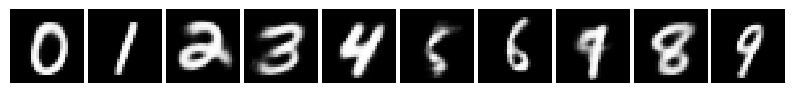

In [ ]:
import matplotlib.gridspec as gridspec
latents = torch.randn(10, latent_dimensionality)
one_hots = torch.eye(10, 10)
latents_and_one_hots = torch.cat((latents, one_hots), dim=-1).to(device='cuda')
cvae_model.eval()
samples = cvae_model.decoder(latents_and_one_hots).data.cpu().numpy()

fig = plt.figure(figsize=(10, 1)) # setting the figure size of 10
gspec = gridspec.GridSpec(1, 10) # this sets each row
gspec.update(wspace=0.06, hspace=0.06)

for i, sample in enumerate(samples):
  ax = plt.subplot(gspec[i])
  plt.axis('off')
  ax.set_xticklabels([]) # remove ticks
  ax.set_yticklabels([]) # remove ticks
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
  plt.savefig(f'your_result_{i}.jpg')

In [ ]:
# !pip install nbconvert
# !apt-get install texlive texlive-xetex texlive-latex-extra pandoc
# !pip install pypandoc

!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/Intro to DL Course/HW3/part3/Copy of part3.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Intro to DL Course/HW3/part3/Copy of part3.ipynb to pdf
[NbConvertApp] Support files will be in Copy of part3_files/
[NbConvertApp] Making directory ./Copy of part3_files
[NbConvertApp] Making directory ./Copy of part3_files
[NbConvertApp] Writing 57971 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 157685 bytes to /content/drive/MyDrive/Colab Notebooks/Intro to DL Course/HW3/part3/Copy of part3.pdf
